## Portfolio simulation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class import PortfolioSimulation

In [2]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})

In [3]:
# LLM recommendations
llm_recommendations1 = pd.read_csv("../data/ciks1_ratings.csv", dtype={"cik": str})
llm_recommendations1.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)
llm_recommendations2 = pd.read_csv("../data/ciks2_ratings.csv", dtype={"CIK": str})
llm_recommendations2.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations3 = pd.read_csv("../data/ciks3_ratings.csv", dtype={"CIK": str})
llm_recommendations3.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations4 = pd.read_csv("../data/ciks4_ratings.csv", dtype={"CIK": str})
llm_recommendations4.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations5 = pd.read_csv("../data/ciks5_ratings.csv", dtype={"CIK": str})
llm_recommendations5.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations6 = pd.read_csv("../data/ciks6_ratings.csv", dtype={"CIK": str})
llm_recommendations6.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  

# Concat all llm recommendations into one DataFrame
llm_recommendations = pd.concat([
    llm_recommendations1, llm_recommendations2, llm_recommendations3,
    llm_recommendations4, llm_recommendations5, llm_recommendations6
], ignore_index=True)

In [4]:
import re

def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

- Subsetting CIK date combinations that are present in LLM recommendations as well as sell-side analyst ratings

In [5]:
# Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M")
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M")
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

In [6]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
# Merge to find common CIK and date combinations
all_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

In [7]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)

In [8]:
len(all_ciks_and_dates), len(llm_recommendations_final), len(analyst_ratings_final)

(40076, 40076, 40076)

---
### Selected stock test simulation 

In [9]:
# Subset 1 CIK for testing
cik = "0001996862"
cik_prices = stock_prices[stock_prices["cik"] == cik]
cik_llm_recommendations = llm_recommendations_final[llm_recommendations_final["cik"] == cik]
cik_analyst_ratings = analyst_ratings[analyst_ratings["cik"] == cik]

In [10]:
start_capital = 100000
cik_sim = PortfolioSimulation(initial_capital = start_capital)
cik_sim.load_stock_prices(cik_prices)
cik_sim.load_recommendations(cik_llm_recommendations)

# Run simulation
cik_sim.simulate_trading()

Simulating Trades:   0%|          | 0/90 [00:00<?, ?it/s]

Simulating Trades: 100%|██████████| 90/90 [00:00<00:00, 1184.03it/s]


In [11]:
cik_sim.portfolio_statistics()

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 969.46it/s]


{'Mean return (monthly)': np.float64(1e-06),
 'Geometric mean return (monthly)': np.float64(1e-06),
 'Standard deviation (monthly)': np.float64(6e-06),
 'Annualized mean return': np.float64(7e-06),
 'Annualized standard deviation': np.float64(2.2e-05),
 'Number of transactions': 5,
 'Number of skipped transactions': 68,
 'Number of buys': 3,
 'Number of sells': 2}

In [12]:
cik_returns = cik_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 916.13it/s]


---

### LLM recommendations simulation

In [14]:
# Initialize portfolio simulation
llm_sim = PortfolioSimulation(initial_capital=start_capital)

# Load data
llm_sim.load_stock_prices(stock_prices)
llm_sim.load_recommendations(llm_recommendations_final)

# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 40076/40076 [09:19<00:00, 71.61it/s]


In [15]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [21:05<00:00,  4.12s/it]


In [16]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.003937),
 'Geometric mean return (monthly)': np.float64(0.003534),
 'Standard deviation (monthly)': np.float64(0.028447),
 'Annualized mean return': np.float64(0.048279),
 'Annualized standard deviation': np.float64(0.098543),
 'Number of transactions': 6668,
 'Number of skipped transactions': 14372,
 'Number of buys': 4092,
 'Number of sells': 2576}

Text(0.5, 0, 'Date')

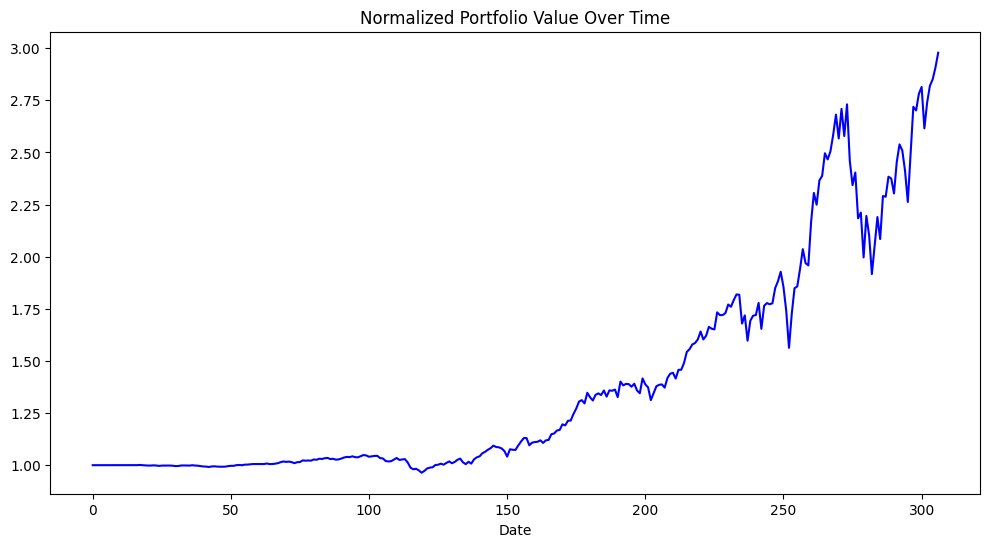

In [17]:
# plot start value over time
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(llm_returns.index, llm_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')

In [55]:
llm_positions = llm_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 298/298 [12:11<00:00,  2.46s/it]


---
### Analyst recommendations simulation

In [20]:
analyst_sim = PortfolioSimulation(initial_capital=start_capital)
analyst_sim.load_stock_prices(stock_prices)
analyst_sim.load_recommendations(analyst_ratings_final)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 40076/40076 [13:50<00:00, 48.26it/s]


In [21]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [06:22<00:00,  1.25s/it]


In [22]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.003159),
 'Geometric mean return (monthly)': np.float64(0.002835),
 'Standard deviation (monthly)': np.float64(0.025482),
 'Annualized mean return': np.float64(0.038573),
 'Annualized standard deviation': np.float64(0.088272),
 'Number of transactions': 1794,
 'Number of skipped transactions': 25609,
 'Number of buys': 1771,
 'Number of sells': 23}

Text(0.5, 0, 'Date')

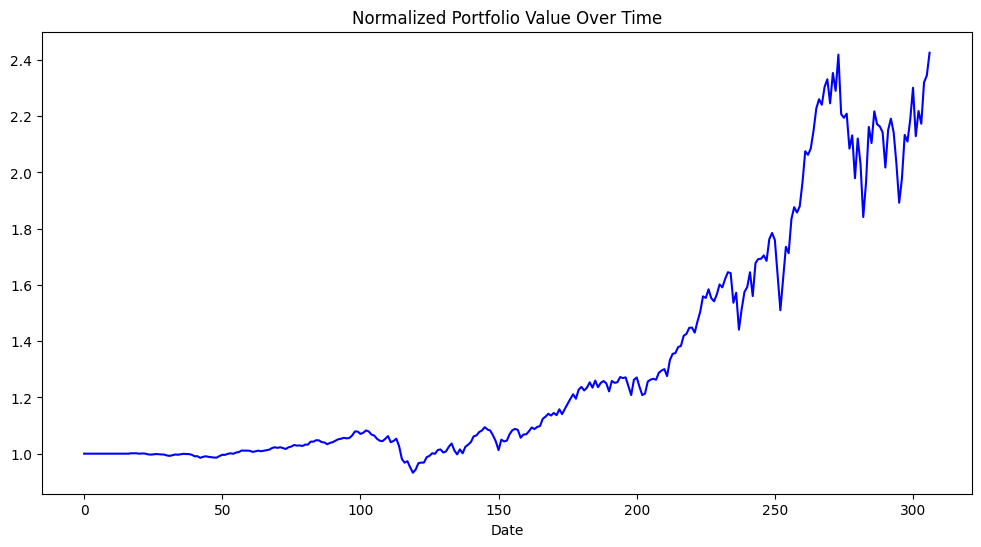

In [23]:
# plot start value over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(analyst_returns.index, analyst_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')

In [29]:
analyst_positions = analyst_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 297/297 [03:00<00:00,  1.64it/s]


In [30]:
analyst_positions

,cik,quantity,total_value
date,,,
2000-01,cash,99964,99964.036418
2000-01,0000014693,1,5.776082
2000-01,0000029644,1,5.156250
2000-01,0000031791,1,25.031250
2000-02,cash,99939,99939.275014
...,...,...,...
2024-09,0000039368,70,5556.600000
2024-09,0000039899,77,1215.060000
2024-09,0000040211,15,1986.750000


In [33]:
df = analyst_positions.reset_index(drop=False)
df

,date,cik,quantity,total_value
0,2000-01,cash,99964,99964.036418
1,2000-01,0000014693,1,5.776082
2,2000-01,0000029644,1,5.156250
3,2000-01,0000031791,1,25.031250
4,2000-02,cash,99939,99939.275014
...,...,...,...,...
9787,2024-09,0000039368,70,5556.600000
9788,2024-09,0000039899,77,1215.060000
9789,2024-09,0000040211,15,1986.750000
9790,2024-09,0000320193,1,233.000000


In [35]:

subset = df[df["date"] == "2015-01"]
subset_cash = subset[subset["cik"] == "cash"]["total_value"].values[0]
subset_cash

np.float64(63278.41314600001)

---

#### Analysis of  PF composition over time 

In [62]:
def plot_pf_shares_over_time(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str)  # Ensure date is string for consistency
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.set_index("date", inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(pf_shares.index, pf_shares["cash_share"], label="Cash Share", color="blue")
    plt.plot(pf_shares.index, pf_shares["stocks_share"], label="Stocks Share", color="orange")
    plt.title("Portfolio Composition Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Share")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


100%|██████████| 297/297 [00:00<00:00, 742.86it/s]


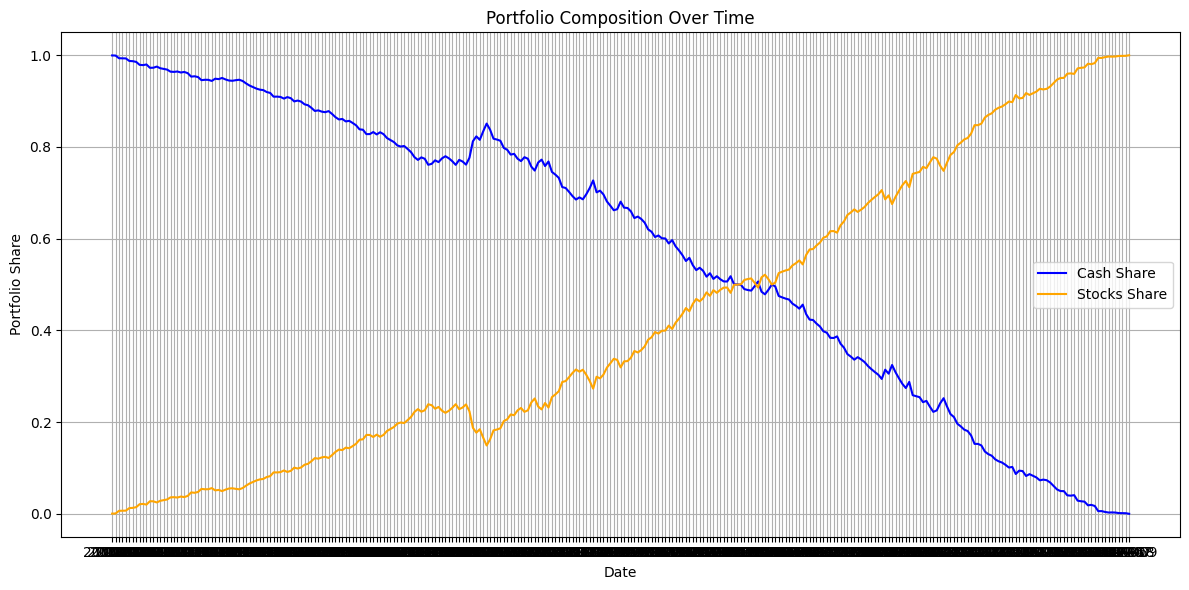

In [50]:
plot_pf_shares_over_time(analyst_positions)

In [58]:
def plot_pf_shares_over_time2(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str) 
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.sort_values("date", inplace=True)
    pf_shares.set_index("date", inplace=True)

    # Stacked area plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        pf_shares.index,
        pf_shares["cash_share"],
        pf_shares["stocks_share"],
        labels=["Cash", "Stocks"],
        colors=["skyblue", "orange"]
    )
    plt.title("Portfolio Composition Over Time")
    plt.ylabel("Portfolio Share")
    plt.ylim(0, 1)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


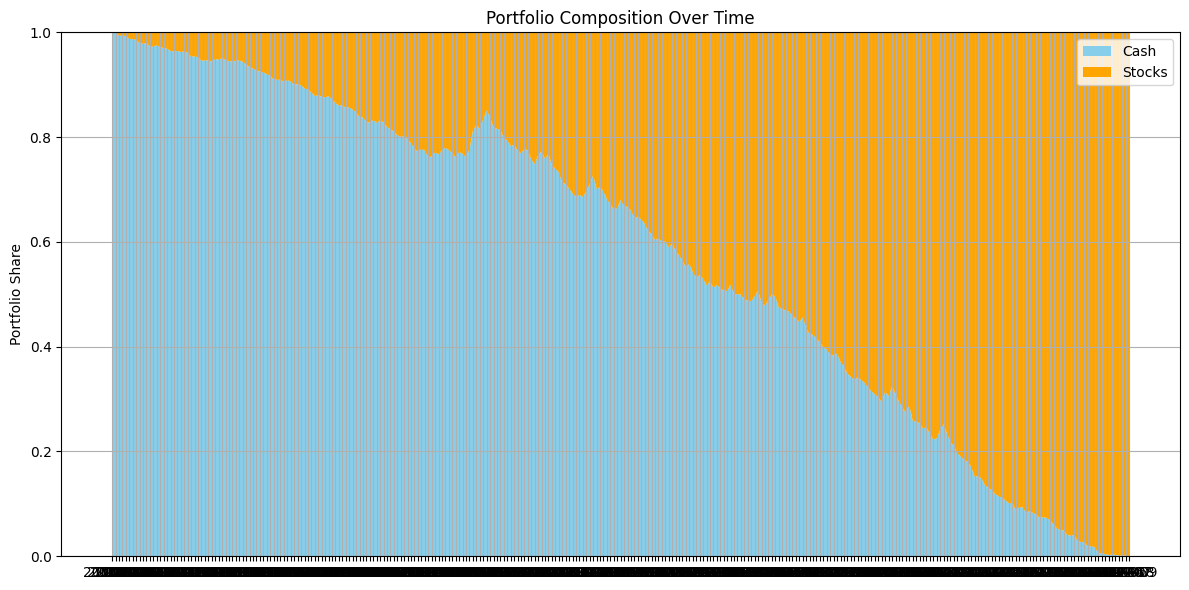

In [59]:
plot_pf_shares_over_time2(analyst_positions)

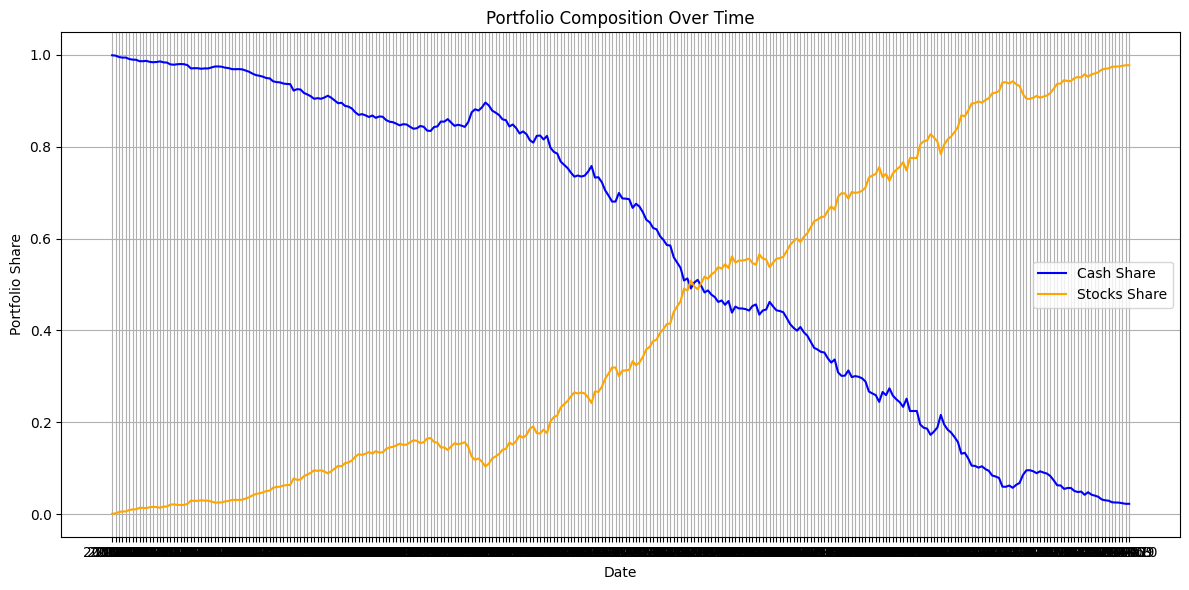

In [63]:
plot_pf_shares_over_time(llm_positions)

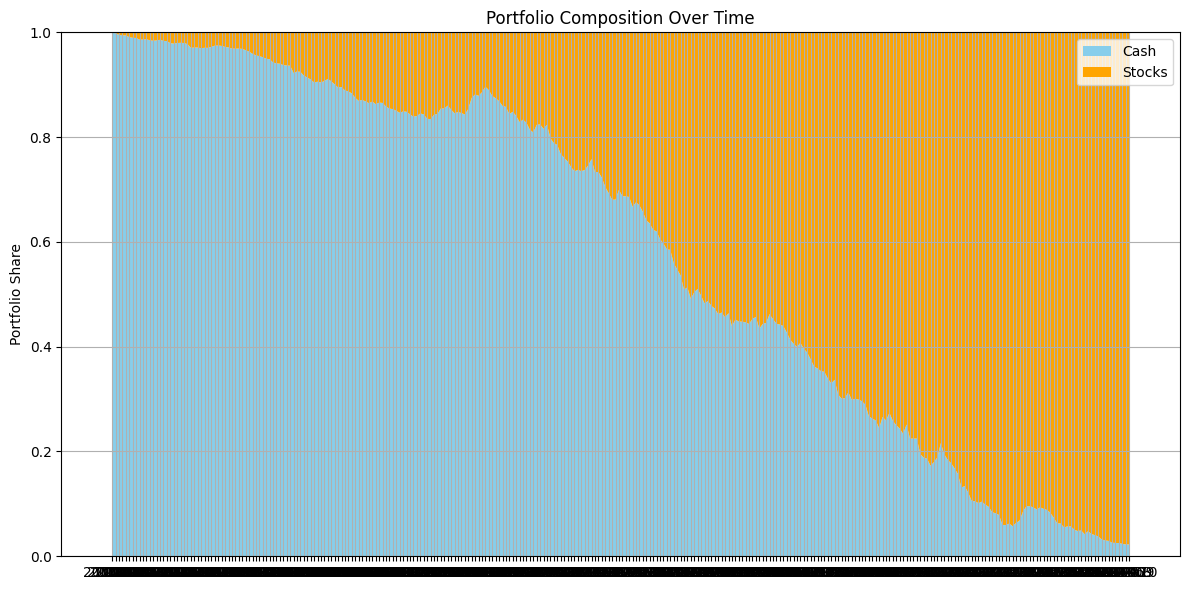

In [61]:
plot_pf_shares_over_time2(llm_positions)